In [4]:
import os
import math

import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, Input, LSTM
from tensorflow import keras
# import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, BayesianOptimization

import matplotlib.pyplot as plt

import re

# Tune MLP

In [2]:
X_train = pd.read_csv("/kaggle/input/final-data/X_train.csv", header = None).to_numpy()
y_train = pd.read_csv("/kaggle/input/final-data/y_train.csv", header = None).to_numpy()

X_test = pd.read_csv("/kaggle/input/final-data/X_test.csv", header = None).to_numpy()
y_test = pd.read_csv("/kaggle/input/final-data/y_test.csv", header = None).to_numpy()

In [7]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape = (X_train.shape[1],)))

    # Tune the number of Dense layers
    for i in range(hp.Int('num_layers', min_value = 1, max_value = 2)):  # Adjust max_value as needed
        model.add(Dense(units = hp.Int('units_' + str(i), min_value = 32, max_value = 128, step = 32), activation = 'relu'))
        
        # Add a dropout layer if selected
        if hp.Boolean('use_dropout'):
            model.add(Dropout(rate = hp.Float('dropout_rate', min_value = 0.2, max_value = 0.5)))

 
    model.add(Dense(units = 1, activation = 'sigmoid'))  # Output layer for classification (adjust as needed)

    # Compile the model
    model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),\
                  loss = 'binary_crossentropy',\
                  metrics = ['accuracy'])
    
    return model

tuner = BayesianOptimization(build_model,\
                             objective = 'val_accuracy',\
                             max_trials = 10,\
                             directory = 'my_tuner_dir',\
                             project_name = 'my_mlp_tuning_2')

In [8]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Trial 10 Complete [00h 12m 26s]
val_accuracy: 0.8621902465820312

Best val_accuracy So Far: 0.8661107420921326
Total elapsed time: 02h 07m 20s


In [9]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 17)                0         
                                                                 
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
best_hparams = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Number of layers: {}".format(best_hparams.get('num_layers')))
print("Number of units_0: {}".format(best_hparams.get('units_0')))
# print("Number of units_1: {}".format(best_hparams.get('units_1')))
# print("Number of units_2: {}".format(best_hparams.get('units_2')))
print("Use dropout: {}".format(best_hparams.get('use_dropout')))
# print("Dropout Rate: {}".format(best_hparams.get('dropout_rate')))
print("Learning Rate: {}".format(best_hparams.get('learning_rate')))

Number of layers: 1
Number of units_0: 128
Use dropout: False
Learning Rate: 0.001


# Create and train MLP

In [8]:
# X_train = pd.read_csv("/kaggle/input/final-data/X_train.csv", header = None).to_numpy()
# y_train = pd.read_csv("/kaggle/input/final-data/y_train.csv", header = None).to_numpy()

# X_test = pd.read_csv("/kaggle/input/final-data/X_test.csv", header = None).to_numpy()
# y_test = pd.read_csv("/kaggle/input/final-data/y_test.csv", header = None).to_numpy()

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [5]:
def create_model(n_features):
    '''
        Create a MLP model.
    '''
    model = Sequential([
        Dense(units = 128, input_shape = (n_features,), activation = 'relu'),
#         Dropout(rate = 0.5),
        Dense(units = 32, activation = 'relu'),
#         Dropout(rate = 0.5),
        Dense(units = 16, activation = 'relu'),
#         Dropout(rate = 0.5),
        Dense(units = 1, activation = 'sigmoid')
    ])
    
    # Compile model.
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

def MinMax_normalization(X_train, X_validation, X_test):
    '''
        Normalize data using MinMax Normalization
        
            Input: Train, validation and test set
            Return: Scaled train, validation and test set
    '''
    
    # Create a scaler based on train dataset.
    scaler_obj = MinMaxScaler()
    X_train_scaled = scaler_obj.fit_transform(X_train)
    
    # Transform validation and test sety based on the training scaler.
    X_validation_scaled = scaler_obj.transform(X_validation)
    X_test_scaled = scaler_obj.transform(X_test)
    
    return X_train_scaled, X_validation_scaled, X_test_scaled

In [ ]:
X = pd.read_csv("/kaggle/input/kfold-thesis-dataset/X.csv", header = None).to_numpy()
y = pd.read_csv("/kaggle/input/kfold-thesis-dataset/y.csv", header = None).to_numpy()

no_folds = 10
kf_obj = KFold(n_splits = no_folds, shuffle = True)

n_features = X.shape[1]

train_results_dict = {}
evaluation_results_dict = {}

for i, (train_index, test_index) in enumerate(kf_obj.split(X, y)):
    print('Fold: {}'.format(i))
    
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_test = X[test_index]
    y_test = y[test_index]
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2)
    
    X_train, X_validation, X_test = MinMax_normalization(X_train, X_validation, X_test)
    
#     print("Train:")
#     print(X_train.shape)
#     print(y_train.shape)
#     print("Validation:")
#     print(X_validation.shape)
#     print(y_validation.shape)
#     print("Test:")
#     print(X_test.shape)
#     print(y_test.shape)
    
    # Create MLP model.
    mlp = create_model(n_features)
    
    # Train MLP on the dataset
    history = mlp.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_validation, y_validation), verbose = 1)
    
    # Save training results: training and validation loss.
    train_results_dict[str(i)] = [history.history['loss'], history.history["val_loss"]]
    
    # Get the predictions of the model.
    y_pred = mlp.predict(X_test)
    y_pred = np.round(y_pred)
    
    # Save evaluation results: Accuracy, Precision, Recall, F1-score.
    evaluation_results_dict[str(i)] = [accuracy_score(y_test, y_pred),\
                                       precision_score(y_test, y_pred),\
                                       recall_score(y_test, y_pred),\
                                       f1_score(y_test, y_pred)
                                    ]
#     break
print('Done')

Fold: 0
Epoch 1/50
33688/33688 [==============================] - 119s 3ms/step - loss: 0.3413 - accuracy: 0.8518 - val_loss: 0.3191 - val_accuracy: 0.8621
Epoch 2/50
33688/33688 [==============================] - 118s 3ms/step - loss: 0.3179 - accuracy: 0.8606 - val_loss: 0.3087 - val_accuracy: 0.8656
Epoch 3/50
33688/33688 [==============================] - 117s 3ms/step - loss: 0.3104 - accuracy: 0.8643 - val_loss: 0.3075 - val_accuracy: 0.8641
Epoch 4/50
33688/33688 [==============================] - 118s 4ms/step - loss: 0.3063 - accuracy: 0.8668 - val_loss: 0.2990 - val_accuracy: 0.8705
Epoch 5/50
33688/33688 [==============================] - 117s 3ms/step - loss: 0.3034 - accuracy: 0.8685 - val_loss: 0.2982 - val_accuracy: 0.8708
Epoch 6/50
33688/33688 [==============================] - 117s 3ms/step - loss: 0.3008 - accuracy: 0.8701 - val_loss: 0.3007 - val_accuracy: 0.8703
Epoch 7/50
33688/33688 [==============================] - 117s 3ms/step - loss: 0.2989 - accuracy: 0.870

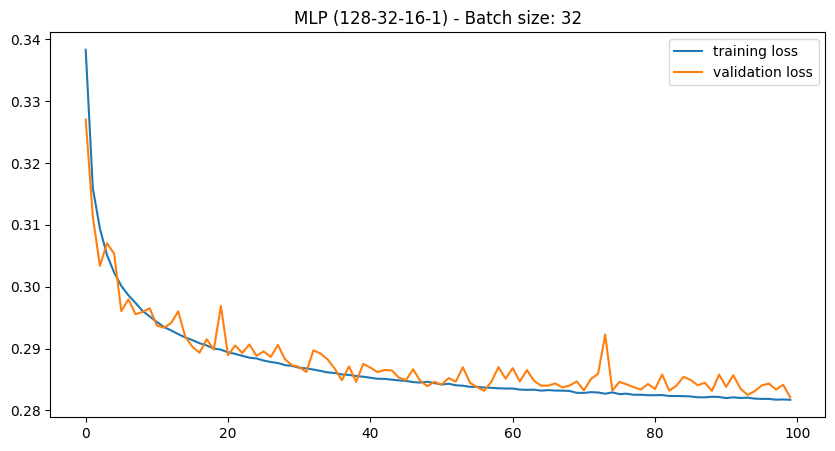

[0.8774820504257806,
 0.9081909251620507,
 0.7718091676960571,
 0.8344643372798152]

In [8]:
plt.figure(figsize = (10, 5))
plt.plot(train_results_dict['0'][0], label = "training loss")
plt.plot(train_results_dict['0'][1], label = "validation loss")
plt.legend()
plt.title('MLP (128-32-16-1) - Batch size: 32')
# plt.savefig('mlp-32_batch_100_epochs')
plt.show()
evaluation_results_dict['0']

In [ ]:
def k_fold_training_results_line_plot(train_results_dict):

    # Create a figure with a 3x3 grid of subplots
    fig, axs = plt.subplots(4, 3, figsize = (15, 10))  # You can adjust the figsize as needed

    # Flatten the axs array for easier iteration
    axs = axs.flatten()

    # Create subplots with two lines in each subplot
    for i, ax in enumerate(axs):
        ax.plot(train_results_dict[str(i)][0], label = 'training loss')
        ax.plot(train_results_dict[str(i)][1], label = 'Validation loss')
        ax.set_title(f'Fold {i + 1}')
        ax.legend()

    # Adjust the layout and spacing
    plt.tight_layout()
    
#     plt.savefig('lstm_loss_plot.png')

    # Show the plots
    plt.show()
    
    
    
k_fold_training_results_line_plot(train_results_dict)

In [15]:
mlp = create_model()

# fit the keras model on the dataset
history = mlp.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_data = (X_val, y_val), verbose = 1)

# a = X_test[0].reshape(1, X_test.shape[1])
# model.predict(a)
results_dict = mlp.evaluate(x = X_test, y = y_test, return_dict = True, verbose = 1)
results_dict

Epoch 1/30
29945/29945 [==============================] - 63s 2ms/step - loss: 0.3412 - accuracy: 0.8513 - val_loss: 0.3237 - val_accuracy: 0.8588
Epoch 2/30
29945/29945 [==============================] - 63s 2ms/step - loss: 0.3188 - accuracy: 0.8604 - val_loss: 0.3146 - val_accuracy: 0.8626
Epoch 3/30
29945/29945 [==============================] - 64s 2ms/step - loss: 0.3120 - accuracy: 0.8640 - val_loss: 0.3080 - val_accuracy: 0.8660
Epoch 4/30
29945/29945 [==============================] - 63s 2ms/step - loss: 0.3072 - accuracy: 0.8662 - val_loss: 0.3076 - val_accuracy: 0.8669
Epoch 5/30
29945/29945 [==============================] - 61s 2ms/step - loss: 0.3041 - accuracy: 0.8680 - val_loss: 0.3046 - val_accuracy: 0.8679
Epoch 6/30
29945/29945 [==============================] - 61s 2ms/step - loss: 0.3020 - accuracy: 0.8691 - val_loss: 0.3070 - val_accuracy: 0.8664
Epoch 7/30
29945/29945 [==============================] - 61s 2ms/step - loss: 0.2999 - accuracy: 0.8700 - val_loss: 0

{'loss': 0.28776195645332336, 'accuracy': 0.8768171072006226}

In [16]:
y_pred = mlp.predict(X_test)
y_pred = np.round(y_pred)

9358/9358 [==============================] - 11s 1ms/step


In [17]:
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('F1-Score: {}'.format(f1_score(y_test, y_pred)))

Accuracy: 0.8768170873838284
Precision: 0.8994445842122578
Recall: 0.8994445842122578
F1-Score: 0.8344352431607531


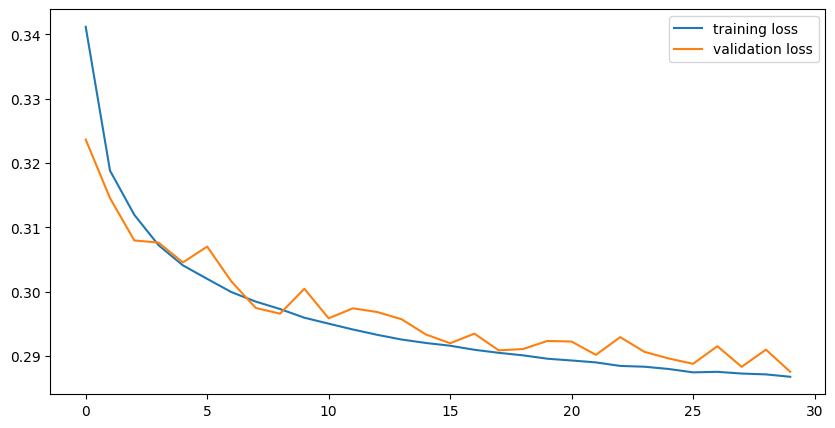

In [18]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

# First Model

In [ ]:
def create_model():
    '''
    The model expects rows of data with 8 variables (the input_shape=(8,) argument).
    The first hidden layer has 12 nodes and uses the relu activation function.
    The second hidden layer has 8 nodes and uses the relu activation function.
    The output layer has one node and uses the sigmoid activation function.
    '''
    model = Sequential([
        Dense(units = 12, input_shape = (X_train.shape[1],), activation = 'relu'),
        Dense(units = 8, activation = 'relu'),
        Dense(units = 1, activation = 'sigmoid')
    ])
    
    # compile the keras model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

X_train, X_test, y_train, y_test = create_dataset()

mlp = create_model()

# fit the keras model on the dataset
history = mlp.fit(X_train, y_train, epochs = 200, batch_size = 32, verbose = 0)

# a = X_test[0].reshape(1, X_test.shape[1])
# model.predict(a)
results_dict = mlp.evaluate(x = X_test, y = y_test, return_dict = True, verbose = 0)
results_dict

In [ ]:
a = X_test[0].reshape(1, X_test.shape[1])
mlp.predict(a)

# Second Model

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape = (X_train.shape[1],)))

    # Tune the number of Dense layers
    for i in range(hp.Int('num_layers', min_value = 1, max_value = 3)):  # Adjust max_value as needed
        model.add(Dense(units = hp.Int('units_' + str(i), min_value = 32, max_value = 512, step = 32),\
                        activation = hp.Choice('activation', values = ['relu', 'sigmoid', 'tanh'])))
        
        # Add a dropout layer if selected
        if hp.Boolean('use_dropout'):
            model.add(Dropout(rate = hp.Float('dropout_rate', min_value = 0.2, max_value = 0.3)))

 
    model.add(Dense(1, activation = 'sigmoid'))  # Output layer for classification (adjust as needed)

    # Compile the model
    model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),\
                  loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
tuner = BayesianOptimization(build_model,\
                             objective = 'val_accuracy',\
                             max_trials = 10,\
                             directory = 'my_tuner_dir',\
                             project_name = 'my_mlp_tuning_1')

In [ ]:
tuner.search(X_train, y_train, epochs = 150, validation_data = (X_test, y_test))

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
best_hparams = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Number of layers: {}".format(best_hparams.get('num_layers')))
print("Number of units: {}".format(best_hparams.get('units_0')))
print("Activation function on each layer: {}".format(best_hparams.get('activation')))
print("Dropout Rate: {}".format(best_hparams.get('dropout_rate')))
print("Learning Rate: {}".format(best_hparams.get('learning_rate')))

In [ ]:
results_dict = best_model.evaluate(x = X_test, y = y_test, return_dict = True, verbose = 0)
results_dict

# Create tune model

In [ ]:
def create_tune_model(X_train):

    model = Sequential([
        Dense(units = 288, input_shape = (X_train.shape[1],), activation = 'relu'),
        Dropout(rate = 0.2),
        Dense(units = 1, activation = 'sigmoid')
    ])
    
    # compile the keras model
    model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(1e-2), metrics = ['accuracy'])
    
    return model

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = create_dataset()

mlp = create_tune_model(X_train)

# fit the keras model on the dataset
history = mlp.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_data = (X_val, y_val), verbose = 0)

# a = X_test[0].reshape(1, X_test.shape[1])
# model.predict(a)
results_dict = mlp.evaluate(x = X_test, y = y_test, return_dict = True, verbose = 0)
results_dict

In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['accuracy'], label = "training accuracy")
plt.plot(history.history['val_accuracy'], label = "validation accuracy")
plt.legend()
plt.show()

# N-grams


In [ ]:
def create_n_grams(word, n):
    '''
    Compute all the n-grams that derive from a word.
        Input: word
        Return: A list with all the n-grams
    '''
    from nltk import ngrams
    
    if(n >= len(word)):
        return []
    
    # Tokenize the word into characters
    characters_lst = list(word)
    
    # Generate character-based bi-grams (n-grams)
    n_grams_lst = list(ngrams(characters, n))
    
    return ["".join(t) for t in n_grams_lst]


create_n_grams("nikos", 2)